In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.initializers import  RandomNormal
from tensorflow.keras.optimizers import Adam
import os
from keras.utils import to_categorical

2024-08-20 10:26:32.213647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 10:26:32.213813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 10:26:32.399360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Minh: Data Augmentation cho các lớp có data nhỏ + khảo sát dataset
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [3]:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
print(len(data[' pixels'].iloc[0].split()))

2304


In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Total image: 35887
 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


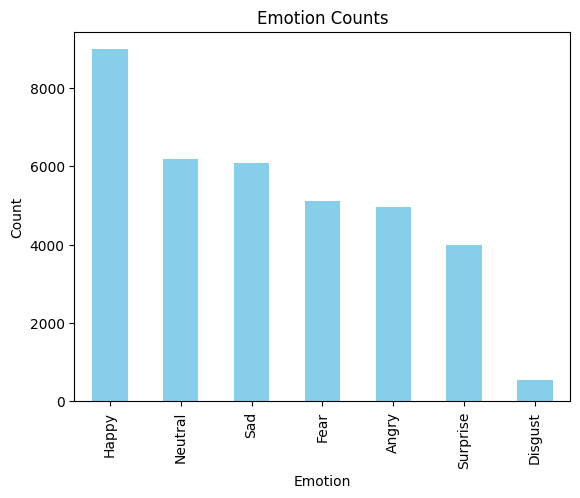

In [6]:
def total_image(data):
    return len(data)

def usage_count(data):
    return data[' Usage'].value_counts()

def plot_class_count(data):
    emotion_counts = data['emotion'].value_counts()
    emotion_counts = emotion_counts.rename(index=emotions)
    emotion_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Counts')
    plt.show()

print("Total image:", total_image(data))
print(usage_count(data))
plot_class_count(data)

In [7]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [8]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
def plot_class_count(data, name):
    # Calculate the counts of each label in the training set
    emotion_counts = np.unique(data, return_counts=True)
    text_labels = [emotions[num] for num in emotion_counts[0]]
    
    # Plot the counts
    plt.bar(text_labels, emotion_counts[1], color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title(f'Emotion Counts in {name} Set')
    plt.show()

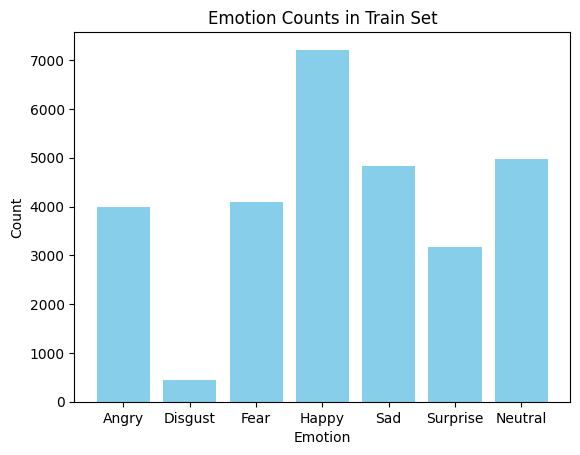

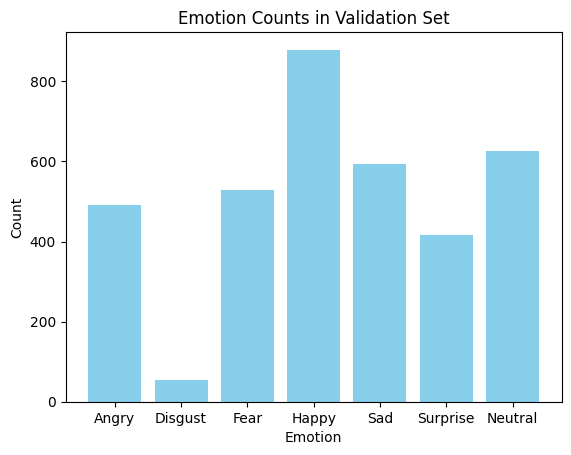

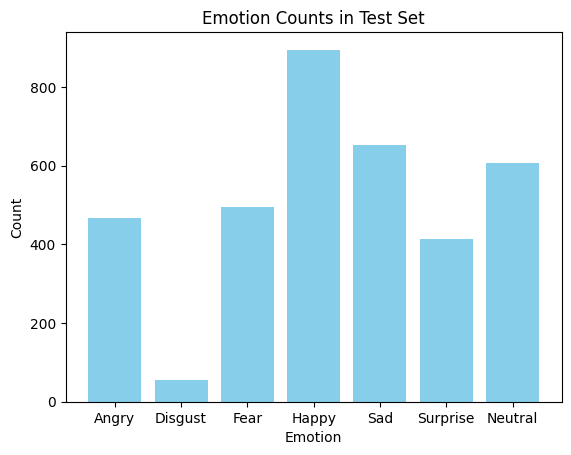

In [10]:
plot_class_count(train_image_label, "Train")
plot_class_count(val_image_label, "Validation")
plot_class_count(test_image_label, "Test")
#data augmention chi lam tren train, test va val de nguyen

In [11]:
IMG_SIZE = 48

def augment(image, seed):
    
    def rotate_image(image, angle):
        # Get the image shape
        height, width = tf.shape(image)[0], tf.shape(image)[1]

        # Compute the center of the image
        center_x, center_y = width / 2.0, height / 2.0

        # Convert angle to radians
        angle_rad = angle * np.pi / 180.0

        # Compute the transformation matrix
        transformation_matrix = [
            tf.cos(angle_rad), -tf.sin(angle_rad), center_x - center_x * tf.cos(angle_rad) + center_y * tf.sin(angle_rad),
            tf.sin(angle_rad), tf.cos(angle_rad), center_y - center_x * tf.sin(angle_rad) - center_y * tf.cos(angle_rad)
        ]

        # Reshape the matrix for tf.image.transform
        transformation_matrix = tf.reshape(transformation_matrix, (2, 3))

        # Apply the affine transformation
        rotated_image = tf.image.transform(image, transformation_matrix, interpolation='BILINEAR')

        return rotated_image
    
    # Convert the image to a TensorFlow tensor if it's not already
#     image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Make a new seed for each augmentation operation
    seed = tf.convert_to_tensor(seed, dtype=tf.int32)

    # Apply various augmentations
    new_seed = tf.random.experimental.stateless_split(seed, num=8)

    # Random brightness adjustment
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed[0])
    
    # Random contrast adjustment
    image = tf.image.stateless_random_contrast(image, lower=0.5, upper=1.5, seed=new_seed[1])
    
    # Random horizontal flip
    image = tf.image.stateless_random_flip_left_right(image, seed=new_seed[3])
    
    # Random vertical flip
    image = tf.image.stateless_random_flip_up_down(image, seed=new_seed[4])
    
    # Generate a random integer k between 0 and 3
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    
    # Rotate the image by 90 degrees k times
    image = tf.image.rot90(image, k=k)
    
    # Random JPEG quality adjustment
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=new_seed[6])

    # Ensure pixel values are within the [0, 1] range
    image = tf.clip_by_value(image, 0, 1)

    return image

# Increase the dataset size by generating N augmented versions of each image
def augment_images(images, labels, N=10):
    """
    Augments images N times using the provided augment_function.

    Args:
      images: A list of images.
      labels: A list of corresponding labels.
      N: The number of augmentations for each image.
      augment_function: The augmentation function to apply.

    Returns:
      A tuple of augmented images and labels as NumPy arrays.
    """

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        for _ in range(N):
            seed = np.random.randint(0, 10000, size=(2,))
            augmented_image = augment(img, seed)
            augmented_images.append(augmented_image.numpy())
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

Original number of disgust images: 436
Original number of disgust label: 436


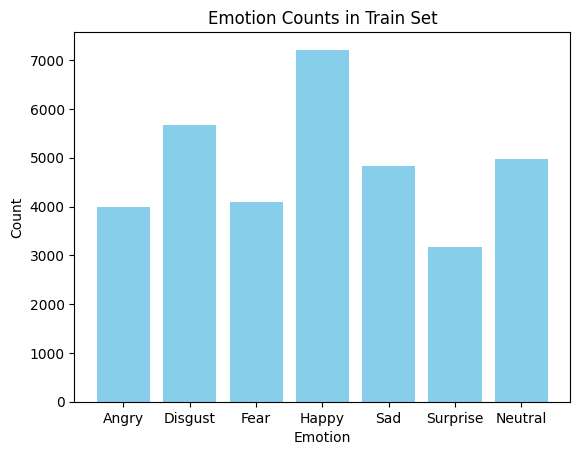

In [12]:
# Augmentation for disgust train dataset: 
label = 1  
N = 12
images_disgust = train_images[np.where(train_image_label == label)[0]]
labels_disgust = train_image_label[np.where(train_image_label == label)[0]]
print(f"Original number of disgust images: {len(images_disgust)}")
print(f"Original number of disgust label: {len(labels_disgust)}")
augmented_images_disgust, augmented_image_label_disgust = augment_images(images= images_disgust, labels= labels_disgust, N=N)
train_images = np.concatenate((train_images, augmented_images_disgust), axis=0)
train_image_label = np.concatenate((train_image_label, augmented_image_label_disgust), axis=0)
#train dataset after augmentation
plot_class_count(train_image_label, "Train")

Original number of surprise images: 3171
Original number of surprise label: 3171


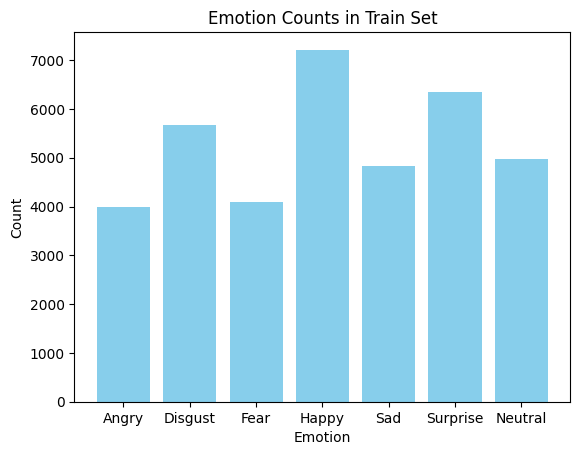

In [13]:
# Augmentation for surprise train dataset: 
label = 5  
N = 1
images_surprise = train_images[np.where(train_image_label == label)[0]]
labels_surprise = train_image_label[np.where(train_image_label == label)[0]]
print(f"Original number of surprise images: {len(images_surprise)}")
print(f"Original number of surprise label: {len(labels_surprise)}")
augmented_images_surprise, augmented_image_label_surprise = augment_images(images= images_surprise, labels= labels_surprise, N=N)
train_images = np.concatenate((train_images, augmented_images_surprise), axis=0)
train_image_label = np.concatenate((train_image_label, augmented_image_label_surprise), axis=0)
#train dataset after augmentation
plot_class_count(train_image_label, "Train")

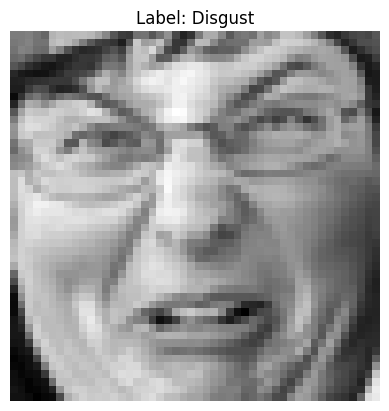

In [14]:
# Accessing the first image with that label
label = 1  
images_disgust = train_images[np.where(train_image_label == label)[0]]
first_image = images_disgust[0]

plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {emotions[label]}")
plt.axis("off")
plt.show()

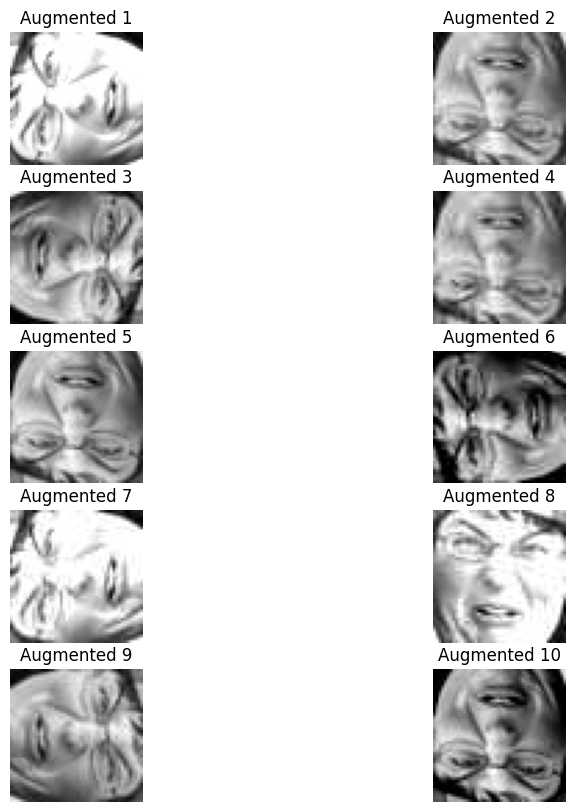

In [15]:
# Displaying the augmented image(s)
fig = plt.figure(figsize=(10,10))
rows = 5
columns = 2

for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(augmented_images_disgust[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Augmented {i+1}")

Original number of disgust images: 55
Original number of disgust label: 55


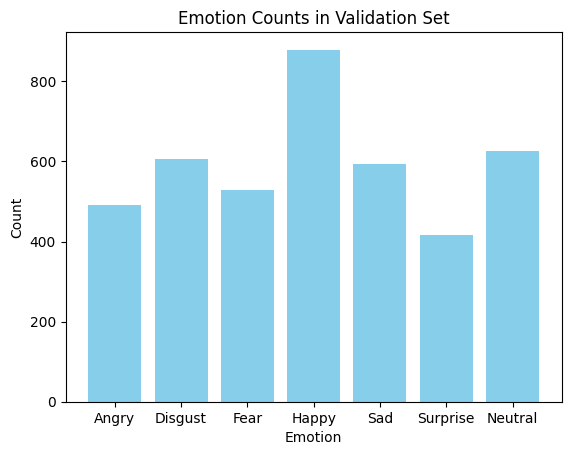

In [16]:
# Augmentation for disgust validation dataset: 
label = 1  
images_disgust = val_images[np.where(val_image_label == label)[0]]
labels_disgust = val_image_label[np.where(val_image_label == label)[0]]
print(f"Original number of disgust images: {len(images_disgust)}")
print(f"Original number of disgust label: {len(labels_disgust)}")

augmented_images, augmented_image_label = augment_images(images= images_disgust, labels= labels_disgust, N= 10)

val_images = np.concatenate((val_images, augmented_images), axis=0)
val_image_label = np.concatenate((val_image_label, augmented_image_label), axis=0)
#Validation dataset after augmentation
plot_class_count(val_image_label, "Validation")


In [17]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [18]:
# Đoàn Anh: Tạo mô hình và huấn luyện mô hình
# model = Sequential()
# model.add(Input(shape=(48, 48, 1)))

# # 1st Convolutional Layer
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

# # 2nd Convolutional Layer
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

# # 3rd Convolutional Layer
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

# # 4th Convolutional Layer
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Flatten())

# # Fully Connected Layer
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # Output Layer
# model.add(Dense(7, activation='softmax'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()

In [19]:
# Use the scheduler for lr in the Adam optimizer
# def scheduler(epoch, lr):
#     if epoch < 20:
#         return lr
#     else:
#         return 0.0001
    
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# checkpoint_path = "best_model.weights.h5"

# model_checkpoint = ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# history = model.fit(train_images, train_labels,
#                     validation_data=(val_images, val_labels), callbacks=[callback, model_checkpoint],
#                     epochs=28, batch_size=128)

In [20]:
# def plot_accuracy(data, size = (20,10)):
#     plt.figure(figsize=size) 
#     plt.plot(data['accuracy'])
#     plt.plot(data['val_accuracy'])
#     plt.title('Model Accuracy', fontsize = 18)
#     plt.ylabel('Accuracy', fontsize = 18)
#     plt.xlabel('Epoch', fontsize = 18)
#     plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
#     plt.tick_params(axis='both', labelsize=14)
#     plt.show()
    
# plot_accuracy(history.history)

In [21]:
# Hùng: Đánh giá mô hình và test mô hình.
# model.load_weights(checkpoint_path)
# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print('test accuracy:', test_acc)

In [22]:
# pred_test_labels = model.predict(test_images)
# pred_test_labels = np.argmax(pred_test_labels, axis=-1)

In [23]:
# cmm = confusion_matrix(test_image_label, pred_test_labels)

# cm_display = ConfusionMatrixDisplay(confusion_matrix = cmm, display_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

# cm_display.plot()
# plt.show()

In [24]:
# report = classification_report(test_image_label, pred_test_labels, target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
# print(report)